In [1]:
%%time
import gc
import xarray as xr
import numpy as np
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs; import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from wrf import (getvar, interplevel,interpline, to_np, latlon_coords, CoordPair, vertcross, 
                 get_cartopy, cartopy_xlim, cartopy_ylim)


from warnings import filterwarnings

filterwarnings('ignore')

CPU times: user 1.28 s, sys: 258 ms, total: 1.54 s
Wall time: 4.84 s


## Path to WRF files

In [2]:
cold_start_path = '/glade/scratch/noteng/lab3/WRF/test/em_real/cold_start/'
restart_path = '/glade/scratch/noteng/lab3/WRF/test/em_real/restart/'

cold_wrfnc = Dataset(cold_start_path+"wrfout_d01_1998-08-01_00:00:00")
restart_wrfnc = Dataset(restart_path+"wrfout_d01_1998-08-02_03:00:00")

## _Vertical Cross Section of U (zonal) component of the wind with lines of constant potential temperature overlaid and mountain fill_

In [3]:
%%time
# Extract the model height, potential temperature, terrain height and wind components
z = getvar(cold_wrfnc, "z")
theta = getvar(cold_wrfnc,'theta')
u = getvar(cold_wrfnc, 'ua')
v = getvar(cold_wrfnc, 'va')
ter = getvar(cold_wrfnc, "ter")


# get the WRF local cosine and sines of the map rotation
cosalpha = cold_wrfnc.variables['COSALPHA'][0]
sinalpha = cold_wrfnc.variables['SINALPHA'][0]

# rotate grid-relative winds to earth-relative using the correct formulas
Ue_wind = u * cosalpha - v * sinalpha


Ze = 10**(Ue_wind/10.) # Use linear Ze for interpolation


#=========================================================
# # # Create the start point and end point for the cross section
start_point = CoordPair(lat=-8.106125, lon=-14.2118225)
end_point = CoordPair(lat=20.827644, lon=16.649506)

#=======================================================

# Compute the vertical cross-section interpolation.  Also, include the lat/lon points along the cross-section.
ze_cross = vertcross(Ze, z, wrfin=cold_wrfnc, start_point=start_point,
                    end_point=end_point, latlon=True, meta=True)


# Convert back to Ue_wind after interpolation
Ue_wind_cross = 10.0 * np.log10(ze_cross)

# Add back the attributes that xarray dropped from the operations above
Ue_wind_cross.attrs.update(ze_cross.attrs)
Ue_wind_cross.attrs["description"] = "destaggered u-wind component"
Ue_wind_cross.attrs["units"] = "$ms^{-1}$"

# To remove the slight gap between the dbz contours and terrain due to the contouring of gridded data, a new vertical grid spacing, and model grid
# staggering, fill in the lower grid cells with the first non-missing value for each column.

# Make a copy of the Ue_wind_cross data. Let's use regular numpy arrays for this.
Ue_wind_cross_filled = np.ma.copy(to_np(Ue_wind_cross))

# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(Ue_wind_cross_filled.shape[-1]):
    column_vals = Ue_wind_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    Ue_wind_cross_filled[0:first_idx, i] = Ue_wind_cross_filled[first_idx, i]


theta_cross = vertcross(theta, z, wrfin=cold_wrfnc, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
                       
ter_line = interpline(ter, wrfin=cold_wrfnc, start_point=start_point,
                      end_point=end_point)

CPU times: user 388 ms, sys: 47.8 ms, total: 435 ms
Wall time: 472 ms


## Creating Figure

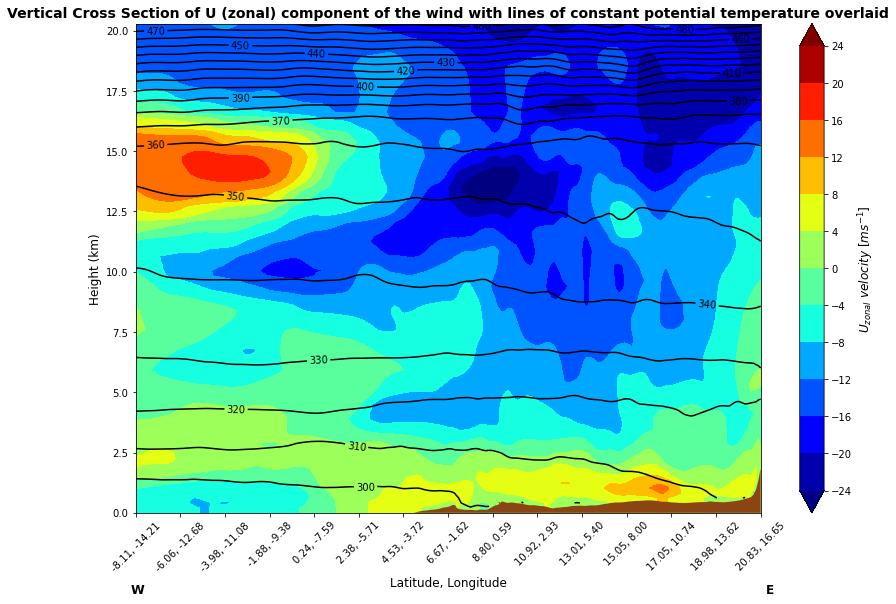

In [4]:

# Create the figure
fig = plt.figure(figsize=(14,9))
fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
ax = plt.axes()

# Make the cross section plot for Ue_wind
xs = np.arange(0, Ue_wind_cross.shape[-1], 1)
ys = to_np(Ue_wind_cross.coords["vertical"])

Ue_wind_levels = np.arange(-24,25,4)
Ue_wind_contours = ax.contourf(xs,ys,to_np(Ue_wind_cross_filled), levels=Ue_wind_levels,
                           cmap='jet', extend="both")

ter_levels = np.arange(0, Ue_wind_cross.shape[1], 1)
# ter_levels = np.arange(0, 281, 1)
# ter_levels = np.arange(0, 41, 1)
theta_levels = np.arange(290,490,10)
theta_contours = ax.contour(xs, ys,to_np(theta_cross), colors='k', levels = theta_levels)
ax.clabel(theta_contours)

#=======================================================
# Fill in the mountain area
ht_fill = ax.fill_between(ter_levels, 0, to_np(ter_line),
                                facecolor="saddlebrown")
#=======================================================

# Add the color bar
cbar = plt.colorbar(Ue_wind_contours, ax=ax, ticks = Ue_wind_levels)
cbar.set_label('$ U_{zonal}$ $velocity$ $[ms^{-1}]$', fontsize=12)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(Ue_wind_cross.coords["xy_loc"])

x_ticks = np.arange(coord_pairs.shape[0])

x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]

ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=10)

# Set the y-ticks to be height.
ax.set_yticklabels(ax.get_yticks()/1e3, fontsize=10)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height (km)", fontsize=12)
fig.text(0.12,0, 'W', fontweight='bold', fontsize=12.5); fig.text(0.75,0, 'E', fontweight='bold', fontsize=12) 

plt.title("Vertical Cross Section of U (zonal) component of the wind with lines of constant potential temperature overlaid", fontsize=14, fontweight='bold')
fig.savefig('./%s.png' %(f'labs4dynamics/lab5/Lab5_noteng-v_transect of u_wind with potential temperature'), dpi=100)